In [30]:
import os, shutil
import numpy as np
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
%matplotlib inline

In [31]:
# Specifying the directory where the image dataset resides.
# There are 3 directories for training, validation, and testing.
# Each directory contains 2 subdirectories for the the 2 class labels. Either Normal or Pneumonia.
# Train contains 1341 nomral images, 3875 pneumonia. Valid contains 8 normal, 8 pneumonia
# Test contains 234 normal, 390 pneumonia.

base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')       # switched test and val directories, since test has much more data
test_dir = os.path.join(base_dir, 'val')              # more validation data is better than less.

In [32]:
# Instantiate the covnet network for classification.

# use available GPU's to train the model.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    
    # use a pre-trained covnet network. Images are grayscale, but pre-trained network only takes 3D tensors.
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
    
    conv_base.summary()

    # freeze layers in covnet base?
    conv_base.trainable = True
    
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False


    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.summary()
    
# Configure model for training

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-5),
                  metrics=['acc'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [33]:
# Process the data into a format that is suitable for the covnet using ImageDataGenerator.

# rescale pixels values to [0,1].
test_datagen = ImageDataGenerator(rescale=1./255)

# augment the training data by applying random transformations to the already available data.
# this helps with over-fitting.
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  # resize images
        batch_size=20,
        class_mode='binary')     # for binary labels    

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [34]:
# Add callbacks to minitor training progress.

callbacks_list = [
#             EarlyStopping(                         # stops training once accuracy drops after 3 epochs.
#             monitor='acc',
#             patience=3,
#         ),
            ModelCheckpoint(                         # saves the weights of the model with the best val accuracy.
            filepath='/kaggle/working/my_model.h5',
            monitor='val_acc',
            save_best_only=True,
        )
#             ReduceLROnPlateau(                     # reduce the optimized learning rate by a 0.1 whenever val loss
#             monitor='val_loss',                    # plateaus for 10 epochs.
#             factor=0.1,
#             patience=10,
#         )
    ]


In [35]:
# Fit the model using batch generator.

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      callbacks=callbacks_list,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 78s 783ms/step - loss: 0.3432 - acc: 0.8460 - val_loss: 0.3387 - val_acc: 0.8702
Epoch 2/10
100/100 [==============================] - 75s 752ms/step - loss: 0.1679 - acc: 0.9360 - val_loss: 0.4090 - val_acc: 0.8542
Epoch 3/10
100/100 [==============================] - 77s 771ms/step - loss: 0.1525 - acc: 0.9394 - val_loss: 0.3149 - val_acc: 0.8830
Epoch 4/10
100/100 [==============================] - 75s 754ms/step - loss: 0.1247 - acc: 0.9545 - val_loss: 0.2358 - val_acc: 0.9087
Epoch 5/10
100/100 [==============================] - 75s 753ms/step - loss: 0.1159 - acc: 0.9579 - val_loss: 0.2399 - val_acc: 0.9103
Epoch 6/10
100/100 [==============================] - 72s 720ms/step - loss: 0.1107 - acc: 0.9625 - val_loss: 0.2656 - val_acc: 0.9071
Epoch 7/10
100/100 [==============================] - 73s 735ms/step - loss: 0.1170 - acc: 0.9565 - val_loss: 0.2677 - val_acc: 0.9071
Epoch 8/10
100/100 [==============================] - 7

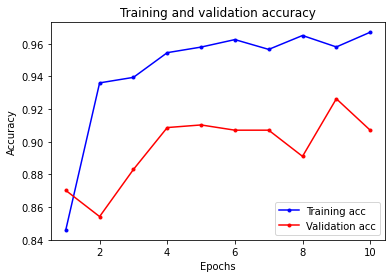

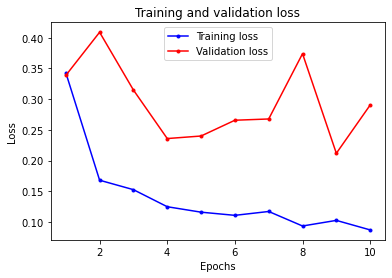

In [36]:
# Plot training loss and accuracy curves.

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b.-', label='Training acc')
plt.plot(epochs, val_acc, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b.-', label='Training loss')
plt.plot(epochs, val_loss, 'r.-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [46]:
# Finally, evaluate model on test data.

# use the model that had best val_acc.
del model
model = models.load_model('my_model.h5')

val_loss, val_acc = model.evaluate_generator(validation_generator, steps=32)
print('validation loss = ',val_loss, ', validation accuracy = ',val_acc*100,'%')

# test accuracy is not a good indicator in this case, due to the very small number of test images.
# for better statistical representation, need many more test images.
test_loss, test_acc = model.evaluate_generator(test_generator, steps=1)
print('test loss = ',test_loss, ', test accuracy = ',test_acc*100,'%')

validation loss =  0.21177715063095093 , validation accuracy =  92.62820482254028 %
test loss =  0.22423523664474487 , test accuracy =  87.5 %
